In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io 
import scipy.optimize

## Anomaly detection

In [2]:
datafile = 'data/ex8data1.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']
ycv = mat['yval']
Xcv = mat['Xval']

In [15]:
def plot_data(myX, newFig=False):
    if newFig:
        plt.figure(figsize=(8,6))
    plt.plot(myX[:,0],myX[:,1],"+")
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')

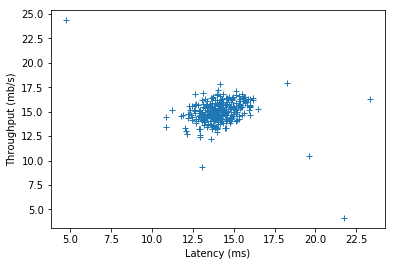

In [16]:
plot_data(X)

In [31]:
def gaussian(myX, mymu, mysig2):
    m = myX.shape[0]
    n = myX.shape[1]
    if np.ndim(mysig2) == 1:
        mysig2 = np.diag(mysig2)

    norm = 1./(np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(mysig2)))
    myinv = np.linalg.inv(mysig2)
    myexp = np.zeros((m,1))
    for irow in range(m):
        xrow = myX[irow]
        myexp[irow] = np.exp(-0.5*((xrow-mymu).T).dot(myinv).dot(xrow-mymu))
    return norm*myexp

In [32]:
def gaussian_params(myX,useMultivariate = True):
    m = myX.shape[0]
    mu = np.mean(myX,axis=0)
    if not useMultivariate:
        sigma2 = np.sum(np.square(myX-mu),axis=0)/float(m)
        return mu, sigma2
    else:
        sigma2 = ((myX-mu).T.dot(myX-mu))/float(m)
        return mu, sigma2

In [33]:
mu, sig2 = gaussian_params(X, useMultivariate = True)

In [34]:
def plot_contours(mymu, mysigma2, newFig=False, useMultivariate = True):
    delta = .5
    myx = np.arange(0,30,delta)
    myy = np.arange(0,30,delta)
    meshx, meshy = np.meshgrid(myx, myy)
    coord_list = [ entry.ravel() for entry in (meshx, meshy) ]
    points = np.vstack(coord_list).T
    myz = gaussian(points, mymu, mysigma2)
    myz = myz.reshape((myx.shape[0],myx.shape[0]))

    if newFig: plt.figure(figsize=(8,6))
    
    cont_levels = [10**exp for exp in range(-20,0,3)]
    mycont = plt.contour(meshx, meshy, myz, levels=cont_levels)

    plt.title('Contours')

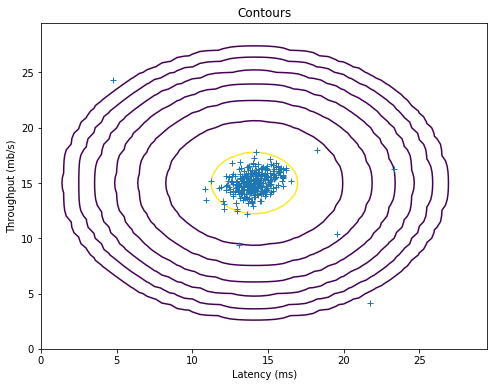

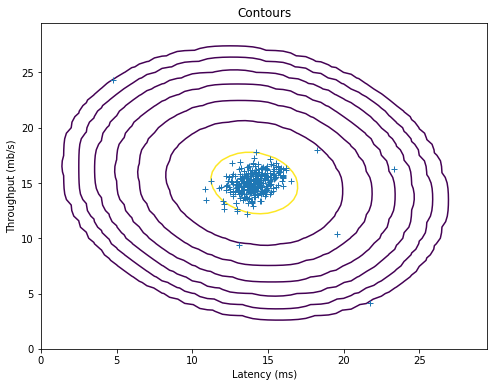

In [35]:
plot_data(X, newFig=True)
useMV = False
plot_contours(*gaussian_params(X, useMV), newFig=False, useMultivariate = useMV)

plot_data(X, newFig=True)
useMV = True
plot_contours(*gaussian_params(X, useMV), newFig=False, useMultivariate = useMV)

In [43]:
def f1_score(predVec, trueVec):
    P, R = 0., 0.
    if float(np.sum(predVec)):
        P = np.sum([int(trueVec[x]) for x in range(predVec.shape[0]) \
                    if predVec[x]]) / float(np.sum(predVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in range(trueVec.shape[0]) \
                    if trueVec[x]]) / float(np.sum(trueVec))
        
    return 2*P*R/(P+R) if (P+R) else 0

In [44]:
def select_thresh(myycv, mypCVs):
    nsteps = 1000
    epses = np.linspace(np.min(mypCVs),np.max(mypCVs),nsteps)
    
    bestF1, bestEps = 0, 0
    trueVec = (myycv == 1).flatten()
    for eps in epses:
        predVec = mypCVs < eps
        thisF1 = f1_score(predVec, trueVec)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEps = eps
            
    print("Best F1 is %f, best eps is %0.4g."%(bestF1,bestEps))
    return bestF1, bestEps

In [45]:
pCVs = gaussian(Xcv, mu, sig2)
bestF1, bestEps = select_thresh(ycv,pCVs)

Best F1 is 0.875000, best eps is 9.075e-05.


In [49]:
def plot_anomalies(myX, mybestEps, newFig = False, useMultivariate = True):
    ps = gaussian(myX, *gaussian_params(myX, useMultivariate))
    anoms = np.array([myX[x] for x in range(myX.shape[0]) if ps[x] < mybestEps])
    if newFig: plt.figure(figsize=(6,4))
    plt.scatter(anoms[:,0],anoms[:,1], s=80, facecolors='none', edgecolors='r')

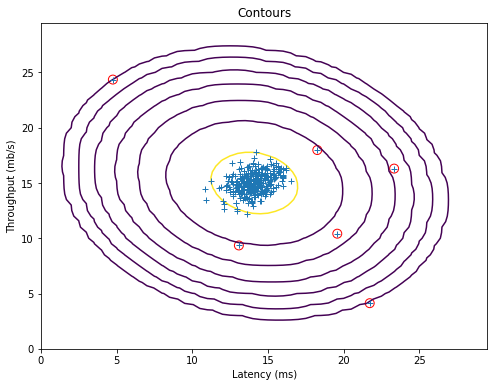

In [50]:
plot_data(X, newFig=True)
plot_contours(mu, sig2, newFig=False, useMultivariate=True)
plot_anomalies(X, bestEps, newFig=False, useMultivariate=True)

## Recommender Systems

In [51]:
datafile = 'data/ex8_movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']

nm, nu = Y.shape

Average rating for movie 1 (Toy Story): 3.88


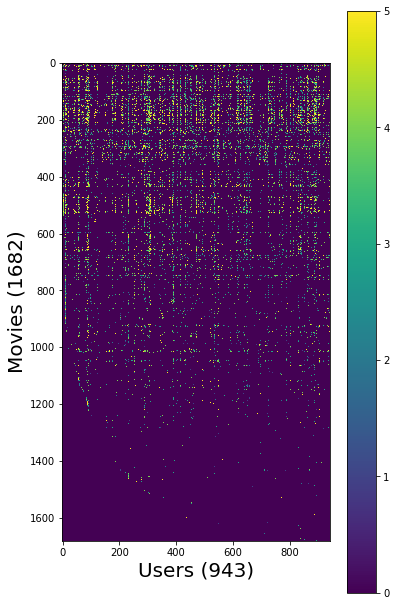

In [53]:
print('Average rating for movie 1 (Toy Story): %0.2f' % np.mean([ Y[0][x] for x in range(Y.shape[1]) if R[0][x] ]))

fig = plt.figure(figsize=(6,6*(1682./943.)))
dummy = plt.imshow(Y)
dummy = plt.colorbar()
dummy = plt.ylabel('Movies (%d)'%nm,fontsize=20)
dummy = plt.xlabel('Users (%d)'%nu,fontsize=20)

In [64]:
datafile = 'data/ex8_movieParams.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']
Theta = mat['Theta']
nu = int(mat['num_users'])
nm = int(mat['num_movies'])
nf = int(mat['num_features'])

nu = 4; nm = 5; nf = 3
X = X[:nm,:nf]
Theta = Theta[:nu,:nf]
Y = Y[:nm,:nu]
R = R[:nm,:nu]

In [65]:
def flatten_params(myX, myTheta):
    return np.concatenate((myX.flatten(),myTheta.flatten()))

def reshape_params(flattened_XandTheta, mynm, mynu, mynf):
    assert flattened_XandTheta.shape[0] == int(nm*nf+nu*nf)
    reX = flattened_XandTheta[:int(mynm*mynf)].reshape((mynm,mynf))
    reTheta = flattened_XandTheta[int(mynm*mynf):].reshape((mynu,mynf))
    return reX, reTheta

In [66]:
def cost(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    myX, myTheta = reshape_params(myparams, mynm, mynu, mynf)
    term1 = myX.dot(myTheta.T)
    term1 = np.multiply(term1,myR)
    cost = 0.5 * np.sum( np.square(term1-myY) )
    cost += (mylambda/2.) * np.sum(np.square(myTheta))
    cost += (mylambda/2.) * np.sum(np.square(myX)) 
    return cost

In [67]:
def gradient(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    myX, myTheta = reshape_params(myparams, mynm, mynu, mynf)
    term1 = myX.dot(myTheta.T)
    term1 = np.multiply(term1,myR)
    term1 -= myY
    Xgrad = term1.dot(myTheta)
    Thetagrad = term1.T.dot(myX)
    Xgrad += mylambda * myX
    Thetagrad += mylambda * myTheta
    return flatten_params(Xgrad, Thetagrad)

In [78]:
movies = []
with open('data/movie_ids.txt', encoding="ISO-8859-1") as f:
    for line in f:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))

my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [79]:
datafile = 'data/ex8_movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']
nf = 10

In [80]:
myR_row = my_ratings > 0
Y = np.hstack((Y,my_ratings))
R = np.hstack((R,myR_row))
nm, nu = Y.shape

In [81]:
def normalize_rating(myY, myR):
    Ymean = np.sum(myY,axis=1)/np.sum(myR,axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    return myY-Ymean, Ymean    

In [82]:
Ynorm, Ymean = normalize_rating(Y,R)

In [83]:
X = np.random.rand(nm,nf)
Theta = np.random.rand(nu,nf)
myflat = flatten_params(X, Theta)
mylambda = 10.
result = scipy.optimize.fmin_cg(cost, x0=myflat, fprime=gradient,args=(Y,R,nu,nm,nf,mylambda),maxiter=50,disp=True,full_output=True)

         Current function value: 72879.933560
         Iterations: 50
         Function evaluations: 70
         Gradient evaluations: 70


In [84]:
resX, resTheta = reshape_params(result[0], nm, nu, nf)

In [85]:
prediction_matrix = resX.dot(resTheta.T)

In [86]:
my_predictions = prediction_matrix[:,-1] + Ymean.flatten()

In [96]:
pred_idxs_sorted = np.argsort(my_predictions)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]
    
print("Original ratings:")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('%s: %d' % (movies[i],my_ratings[i]))
        
print("\nRecommendations")
for i in range(10):
    print('%s: %0.1f' % (movies[pred_idxs_sorted[i]],my_predictions[pred_idxs_sorted[i]]))

Original ratings:
Toy Story (1995): 4
Twelve Monkeys (1995): 3
Usual Suspects, The (1995): 5
Outbreak (1995): 4
Shawshank Redemption, The (1994): 5
While You Were Sleeping (1995): 3
Forrest Gump (1994): 5
Silence of the Lambs, The (1991): 2
Alien (1979): 4
Die Hard 2 (1990): 5
Sphere (1998): 5

Recommendations
Star Wars (1977): 8.6
Shawshank Redemption, The (1994): 8.4
Schindler's List (1993): 8.3
Titanic (1997): 8.3
Raiders of the Lost Ark (1981): 8.2
Usual Suspects, The (1995): 8.1
Close Shave, A (1995): 8.1
Wrong Trousers, The (1993): 8.1
Good Will Hunting (1997): 8.1
Casablanca (1942): 8.0
